In [1]:
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from utils import *
from model import getModel

In [2]:
pd = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(pd[0], True)
except:
    ## GPU not found
    pass

## Build model

In [3]:
def predict(x_idx=None):
    x = np.random.normal(size=(32, imgSize, imgSize, 3))
    for i in range(timeSteps):
        t = i
        x = diffModel.predict([x, np.full((32), t)], verbose=0)
    showExamples(x)

In [4]:
def trainOne(x):
    timeSteps = generateTimeSteps(len(x), 10)
    xa, xb = forwardNoise(x, timeSteps, timeBar)
    loss = diffModel.train_on_batch([xa, timeSteps], xb)
    return loss

### load CIFAR car data

In [5]:
#(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.cifar10.load_data()

In [6]:
'''
print(len(xtrain), np.min(np.unique(xtrain)), np.max(np.unique(xtrain)))

#select training images that are cars
xtrain = xtrain[ytrain.squeeze()==1]

#normalize to adjust intensity between -1 and 1
xtrain = (xtrain/127.5)-1

print(len(xtrain), np.min(np.unique(xtrain)), np.max(np.unique(xtrain)))
'''

'\nprint(len(xtrain), np.min(np.unique(xtrain)), np.max(np.unique(xtrain)))\n\n#select training images that are cars\nxtrain = xtrain[ytrain.squeeze()==1]\n\n#normalize to adjust intensity between -1 and 1\nxtrain = (xtrain/127.5)-1\n\nprint(len(xtrain), np.min(np.unique(xtrain)), np.max(np.unique(xtrain)))\n'

### load dandlion data

In [7]:
dand = np.load('dandelion.npy')
print(np.shape(dand))

xtrain, xtest = train_test_split(dand, test_size=0.1, random_state=45)
print(np.shape(xtrain),  np.min(np.unique(xtrain)), np.max(np.unique(xtrain)))
xtrain = (xtrain/127.5)-1
print(np.shape(xtrain),  np.min(np.unique(xtrain)), np.max(np.unique(xtrain)))


(359, 240, 240, 3)
(323, 240, 240, 3) 0 255
(323, 240, 240, 3) -1.0 1.0


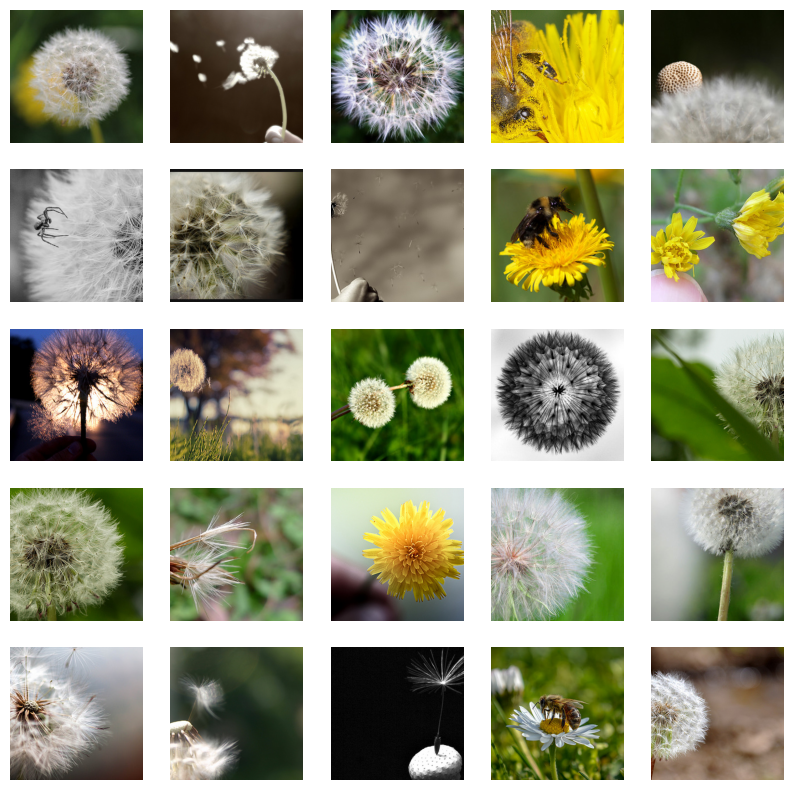

In [8]:
showExamples(xtrain)

In [9]:
# hyperparameters
imgSize = 240
batchSize = 128
epochs = 20
timeSteps = 10
timeBar = 1 - np.linspace(0,1, timeSteps + 1)


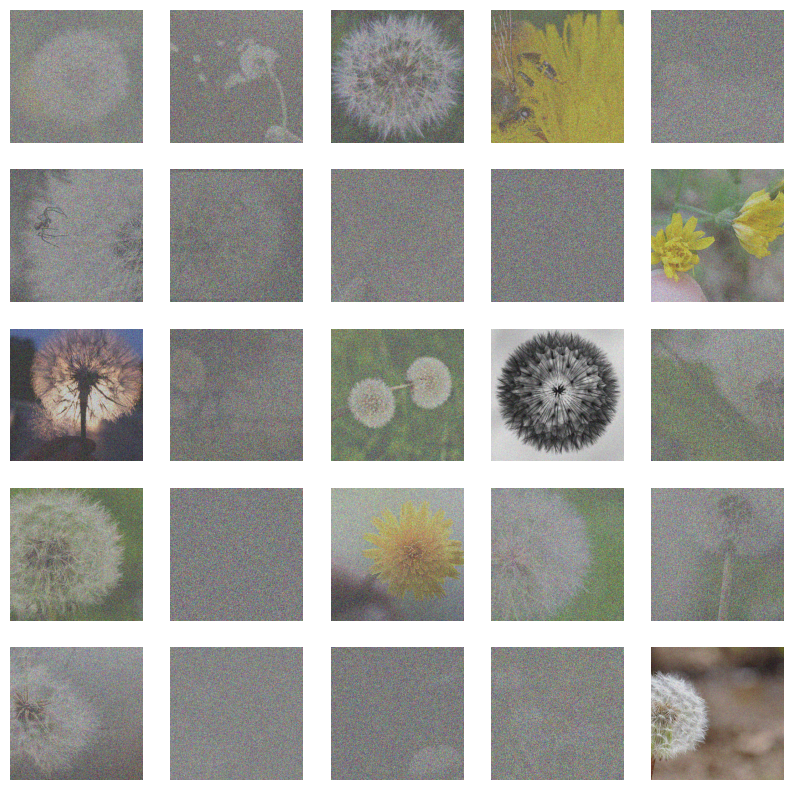

In [10]:
t = generateTimeSteps(25, timeSteps)
a,b = forwardNoise(xtrain[:25], t, timeBar)
showExamples(a)

### get the diffusion model

In [11]:
diffModel = getModel(imgSize)
diffModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_ts_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 192)          384         ['x_ts_input[0][0]']             
                                                                                                  
 layer_normalization (LayerNorm  (None, 192)         384         ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 192)          0           ['layer_normalization[0][0]']

In [12]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
diffModel.compile(loss = tf.keras.losses.MeanSquaredError(),
              optimizer  = opt)

In [13]:
diffModel.load_weights("diffusion-dandelion.keras")

### train

In [ ]:
b = range(50)
total = trange(100)

for e in range(epochs):
    for i in b:
        for j in total:
            x = xtrain[np.random.randint(len(xtrain), size=batchSize)]
            loss = trainOne(x)
            
        if i%10==0:
            diffModel.save("diffusion-dandelion-epoch"+str(e+20)+"-iter"+str(i)+".keras")
            print("epoch: ", e, "\t i: ", i, "\t loss:", loss)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:  0 	 i:  0 	 loss: 0.001229165238328278
epoch:  0 	 i:  10 	 loss: 0.0011225533671677113
epoch:  0 	 i:  20 	 loss: 0.0011087300954386592
epoch:  0 	 i:  30 	 loss: 0.0010929153067991138
epoch:  0 	 i:  40 	 loss: 0.0011396073969081044
epoch:  1 	 i:  0 	 loss: 0.001079161767847836
epoch:  1 	 i:  10 	 loss: 0.001061407383531332
epoch:  1 	 i:  20 	 loss: 0.0008690531249158084


In [ ]:
diffModel.save("diffusion-dandelion.keras")
predict()

In [ ]:
### load and predict 

In [ ]:
predict()